In [1]:
import torch
import matplotlib.pyplot as plt

# 最小二乘法


### 示例1：线性拟合

[随机参数]a=0.582 b=1.988
[估计参数]a=0.580 b=1.994


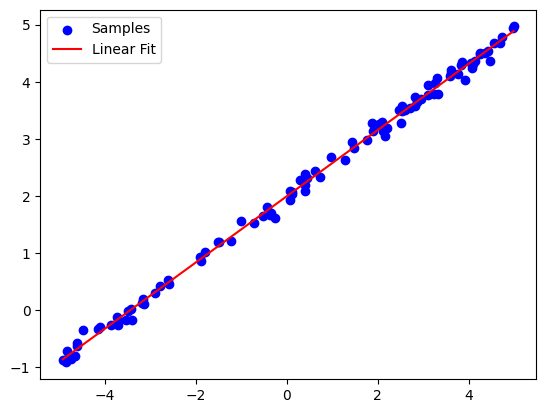

In [81]:
X = torch.rand([100,1])*10-5
a = torch.randn([]) # 标量
b = torch.randn([])
Y = a*X+b+torch.randn([100,1])*0.1 # 加性高斯噪声
print("[随机参数]a={:.3f} b={:.3f}".format(a,b))

plt.figure()
plt.scatter(X,Y,c='b',label="Samples")

# 增广
A = torch.cat([X,torch.ones([100,1])],dim=1)
# 最小二乘法
W = torch.inverse(A.T @ A) @ A.T @ Y # (2,1)
print("[估计参数]a={:.3f} b={:.3f}".format(W[0].item(),W[1].item()))
# 绘制直线
X = torch.tensor([X.min(),X.max()]) # (2,)
Y = W[0]*X+W[1]

plt.plot(X,Y,c='r',label="Linear Fit")
plt.legend()
plt.show()

### 示例2：多项式拟合

【随机生成】3次多项式函数
[0阶系数]0.626
[1阶系数]0.799
[2阶系数]0.820
[3阶系数]0.105
【参数估计】
[0阶系数]0.617
[1阶系数]0.807
[2阶系数]0.820
[3阶系数]0.105


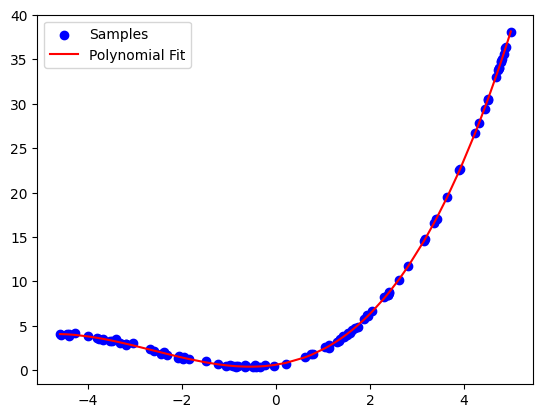

In [82]:
X = torch.rand([100,1])*10-5
N = torch.randint(2,4,[]) # N次多项式
print("【随机生成】{}次多项式函数".format(N))

W = torch.rand([N+1,]) # 零次项的系数也要存储
Y = torch.zeros([100,1])
A = []
for n in range(0,N+1):
    print("[{}阶系数]{:.3f}".format(n,W[n]))
    Xn = torch.pow(X,n)
    A.append(Xn)
    Y += Xn*W[n]
Y += torch.randn([100,1])*0.1 # 加性高斯噪声

plt.figure()
plt.scatter(X,Y,c='b',label="Samples")

# 增广
A = torch.cat(A,dim=1) # (100,N)
# 最小二乘法
W = torch.inverse(A.T @ A) @ A.T @ Y # (N,1)
print("【参数估计】")
for n in range(0,N+1):
    print("[{}阶系数]{:.3f}".format(n,W[n].item()))
# 绘制曲线
X,sort_idx = torch.sort(X,dim=0) # 排序索引
A = A[sort_idx.flatten(),:]
Y = A @ W
plt.plot(X,Y,c='r',label="Polynomial Fit")
plt.legend()
plt.show()

# 加权最小二乘法

[随机参数]a=-1.135 b=0.373
[普通估计]a=-0.000 b=-0.198
[加权估计]a=-0.980 b=1.519


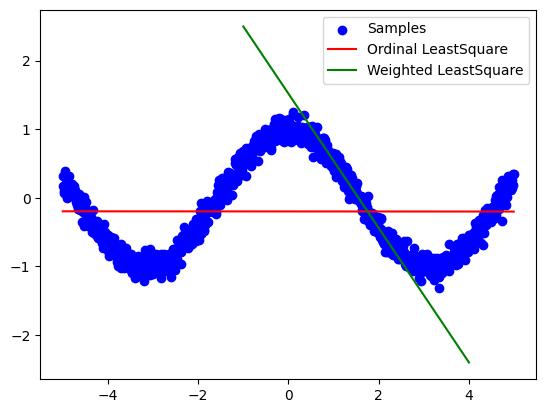

In [107]:
X = torch.arange(-5,5,0.01).reshape([-1,1]) # (N,1)
N = X.shape[0]
a = torch.randn([]) # 标量
b = torch.randn([])
Y = torch.cos(X)+torch.randn_like(X)*0.1 # 加性高斯噪声
print("[随机参数]a={:.3f} b={:.3f}".format(a,b))

plt.figure()
plt.scatter(X,Y,c='b',label="Samples")

# 增广
A = torch.cat([X,torch.ones_like(X)],dim=1)
# 普通最小二乘法
W = torch.inverse(A.T @ A) @ A.T @ Y # (2,1)
print("[普通估计]a={:.3f} b={:.3f}".format(W[0].item(),W[1].item()))
# 绘制直线
X_hat = torch.tensor([X.min(),X.max()]) # (2,)
Y_hat = W[0]*X_hat+W[1]
plt.plot(X_hat,Y_hat,c='r',label="Ordinal LeastSquare")
# 加权最小二乘法
E = torch.zeros([N,N])
idx = torch.where((X>torch.pi*1/4) & (X<torch.pi*3/4))[0] # 只使用pi/2附近的点
E[idx,idx] = 1
W = torch.inverse(A.T @ E @ A) @ A.T @ E @ Y # (2,1)
print("[加权估计]a={:.3f} b={:.3f}".format(W[0].item(),W[1].item()))
# 绘制直线
X_hat = torch.tensor([-1,4])
Y_hat = W[0]*X_hat+W[1]
plt.plot(X_hat,Y_hat,c='g',label="Weighted LeastSquare")

plt.legend()
plt.show()

# Woodbury矩阵恒等式


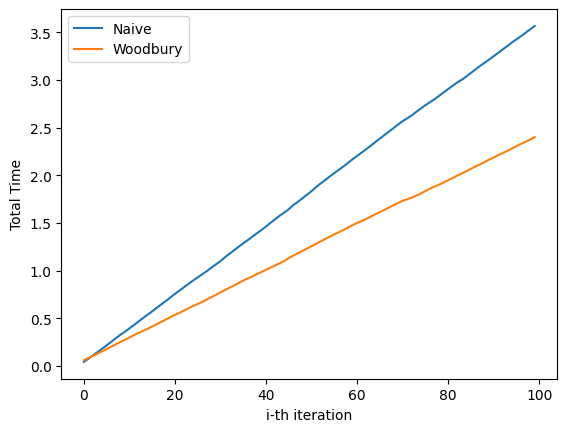

In [13]:
import time

N = 1000
M = 10
T = 100

T0 = []
T1 = []
A  = torch.randn([N,N])
A_ = None
for t in range(0,T):
    B = torch.randn([N,M])
    C = torch.randn([M,M])
    D = torch.randn([M,N])

    t0 = time.perf_counter()
    Y_1 = torch.inverse(A+B@C@D)
    t1 = time.perf_counter()
    t = t1-t0
    T0.append(t)

    t0 = time.perf_counter()
    if(A_ is None):
        A_ = torch.inverse(A)
    else:
        A_ = Y_2
    C_ = torch.inverse(C)
    Y_2 = A_ - A_ @ B @ torch.inverse(C_+D@A_@B)@D@A_
    t1 = time.perf_counter()
    t = t1-t0
    T1.append(t)
    
T0 = torch.cumsum(torch.tensor(T0),dim=0)
T1 = torch.cumsum(torch.tensor(T1),dim=0)
plt.plot(T0,label="Naive")
plt.plot(T1,label="Woodbury")
plt.xlabel("i-th iteration")
plt.ylabel("Total Time")
plt.legend()
plt.show()


# 递归最小二乘法

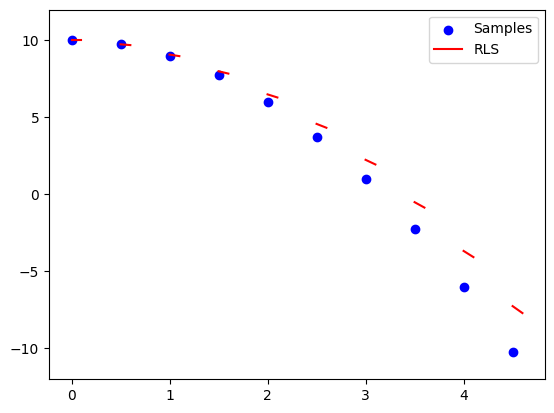

In [9]:
X = torch.arange(0,5,0.5).reshape([-1,1]) # (N,1)
Y = 10 - torch.square(X)

N = X.shape[0]
X = torch.cat([X,torch.ones(N,1)],dim=1) # 增广 (N,2)
D = X.shape[1]

w = torch.zeros([2,1])
P = torch.eye(D) * 1e6 # 使用对角阵初始化，保证可逆
# 注意，精度矩阵和协方差矩阵是反过来的，所以初始值越大越好

plt.figure()
plt.scatter(X[:,0],Y,c='b',label="Samples")

for t in range(0,N):
    x = X[t:t+1,:]
    y = Y[t:t+1]
    y_hat = x @ w
    epsilon = y - y_hat
    P -= (P @ x.T @ x @ P) / (1+ x @ P @ x.T)
    K  = P @ x.T
    w += K * epsilon

    # 避免legend重复显示
    if(t==0): 
        tip = "RLS"
    else:
        tip = None
    # 绘制每轮迭代的估计结果
    x0 = x[0,0]
    x1 = x0+0.1
    x  = torch.stack([x0,x1])
    y = w[0]*x+w[1]
    plt.plot(x,y,label=tip,color="r")



plt.ylim([-12,12])
plt.legend()
plt.show()

### 带遗忘因子的递归最小二乘法

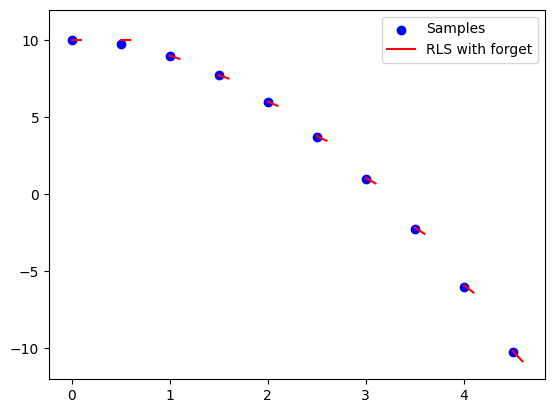

In [30]:
X = torch.arange(0,5,0.5).reshape([-1,1]) # (N,1)
Y = 10 - torch.square(X)

N = X.shape[0]
X = torch.cat([X,torch.ones(N,1)],dim=1) # 增广 (N,2)
D = X.shape[1]

w = torch.zeros([2,1])
P = torch.eye(D) * 1e6 # 使用对角阵初始化，保证可逆
# 注意，精度矩阵和协方差矩阵是反过来的，所以初始值越大越好

plt.figure()
plt.scatter(X[:,0],Y,c='b',label="Samples")

LAMBDA = 0.1

for t in range(0,N):
    x = X[t:t+1,:]
    y = Y[t:t+1]
    y_hat = x @ w
    epsilon = y - y_hat
    P  = (1/LAMBDA)* P - (1/LAMBDA) * (P @ x.T @ x @ P) / (LAMBDA+ x @ P @ x.T)
    K  = P @ x.T
    w += K * epsilon

    # 避免legend重复显示
    if(t==0): 
        tip = "RLS with forget"
    else:
        tip = None
    # 绘制每轮迭代的估计结果
    x0 = x[0,0]
    x1 = x0+0.1
    x  = torch.stack([x0,x1])
    y = w[0]*x+w[1]
    plt.plot(x,y,label=tip,color="r")



plt.ylim([-12,12])
plt.legend()
plt.show()

- 可以看到，通过遗忘旧样本，RLS成功拟合了非线性函数的局部线性趋势